<a href="https://colab.research.google.com/github/MYoussef885/Breast_Cancer_Classification_using_NN/blob/main/Breast_Cancer_Classification_with_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle

# 1. Load Data
df = pd.read_csv('/content/BreastCancerDataset.csv')

# 2. Cleaning
# Drop 'id' (useless) and 'Unnamed: 32' (common error in this dataset)
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

# 3. Encode Target
# M = Malignant (1), B = Benign (0)
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

# 4. Define X and y
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# 5. Split Data (Stratify ensures we keep the same % of cancer cases in train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Standardization (CRITICAL for Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check Class Balance
print("Dataset Shape:", df.shape)
print("Class Balance:\n", df['diagnosis'].value_counts(normalize=True))

Dataset Shape: (569, 31)
Class Balance:
 diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64


/tmp/ipython-input-2245927884.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='coolwarm')


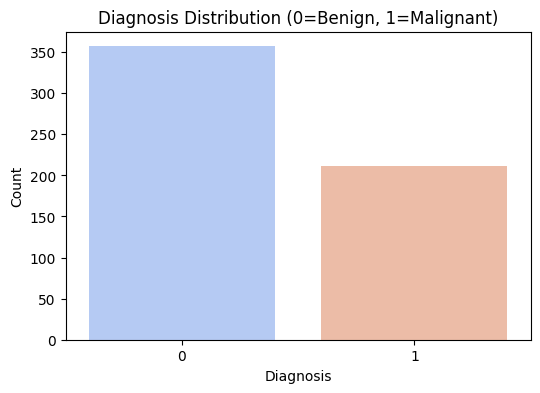

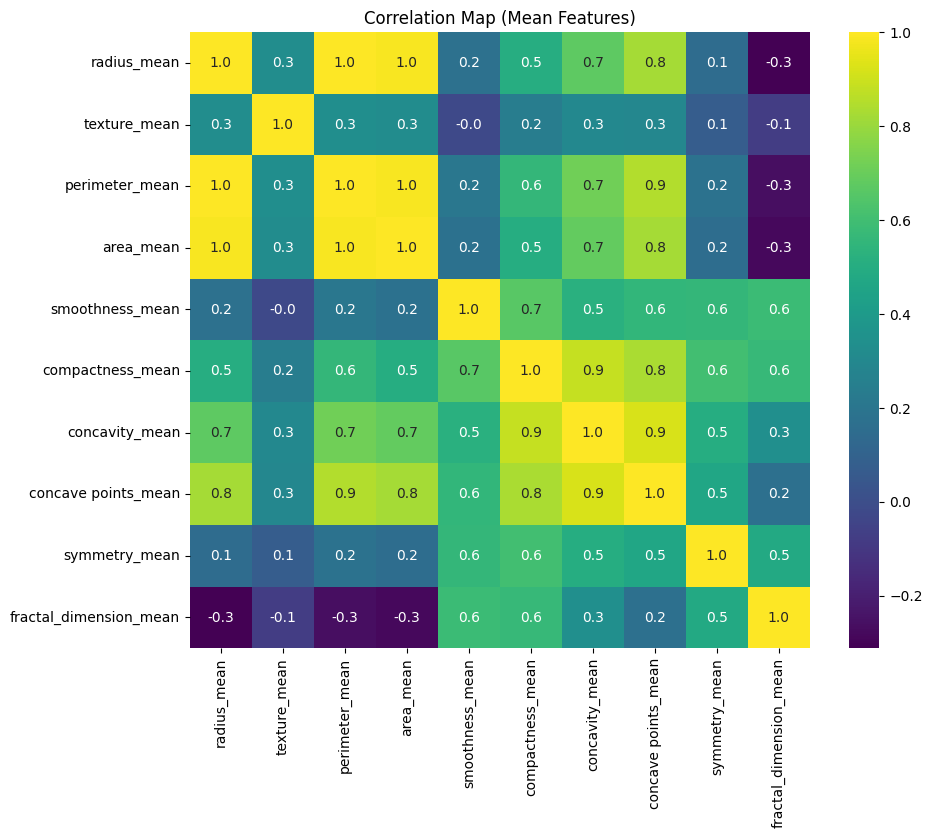

/tmp/ipython-input-2245927884.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='diagnosis', y=feature, data=df, palette='muted', split=True)
/tmp/ipython-input-2245927884.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='diagnosis', y=feature, data=df, palette='muted', split=True)
/tmp/ipython-input-2245927884.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='diagnosis', y=feature, data=df, palette='muted', split=True)


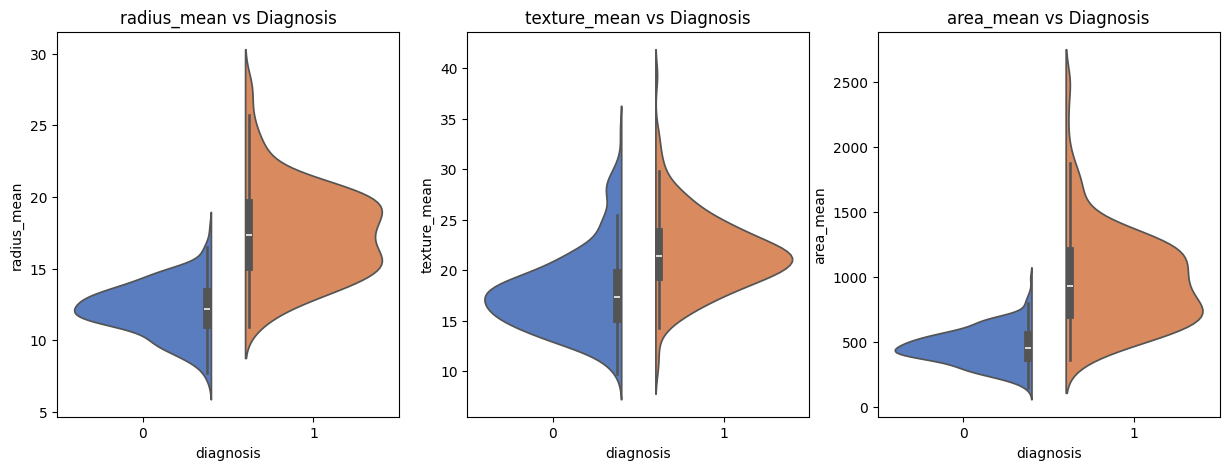

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Target Distribution (The Imbalance Visualized)
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='coolwarm')
plt.title('Diagnosis Distribution (0=Benign, 1=Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# 2. Correlation Heatmap (Focusing on 'Mean' features only)
# We select only columns ending with '_mean' to keep the chart readable
mean_cols = [c for c in df.columns if 'mean' in c]
plt.figure(figsize=(10, 8))
sns.heatmap(df[mean_cols].corr(), annot=True, fmt='.1f', cmap='viridis')
plt.title('Correlation Map (Mean Features)')
plt.show()

# 3. Violin Plots (Better than Boxplots for Medical Data)
# Shows the density of the data at different values
features_to_check = ['radius_mean', 'texture_mean', 'area_mean']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_check):
    plt.subplot(1, 3, i+1)
    sns.violinplot(x='diagnosis', y=feature, data=df, palette='muted', split=True)
    plt.title(f'{feature} vs Diagnosis')
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight # <--- 1. NEW IMPORT
import numpy as np

# --- 2. NEW: Calculate Class Weights ---
# This tells the model: "Pay more attention to the Malignant class!"
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Convert to dictionary format {0: weight, 1: weight} which Keras needs
weights_dict = {i : class_weights_array[i] for i in range(len(class_weights_array))}
print(f"⚖️ Calculated Class Weights: {weights_dict}")

# 3. Build the Network (Same as before)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# 4. Compile (Same as before)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Smart Training (Same as before)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 6. Train with Weights (The Magic Fix)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=weights_dict,  # <--- 7. NEW: Add this line here!
    verbose=1
)

⚖️ Calculated Class Weights: {0: np.float64(0.7982456140350878), 1: np.float64(1.338235294117647)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6137 - loss: 0.6725 - val_accuracy: 0.4396 - val_loss: 0.6489
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8811 - loss: 0.3429 - val_accuracy: 0.8571 - val_loss: 0.5108
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9032 - loss: 0.2507 - val_accuracy: 0.9341 - val_loss: 0.4121
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9382 - loss: 0.2215 - val_accuracy: 0.9341 - val_loss: 0.3475
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9541 - loss: 0.1698 - val_accuracy: 0.9341 - val_loss: 0.2964
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9547 - loss: 0.1672 - val_accuracy: 0.9341 - val_loss: 0.2603
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9446 - loss: 0.1577 - val_accuracy: 0.9451 - val_loss: 0.2283
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9582 - loss: 0.1523 - val_accuracy: 0.9560 - val_loss: 0

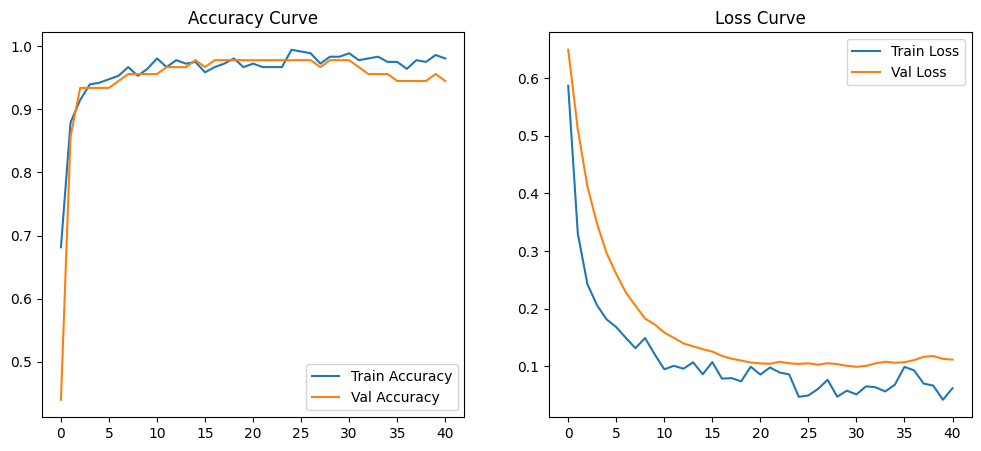

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


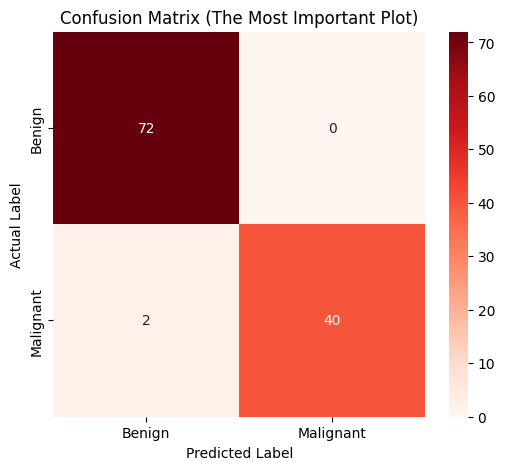

              precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        72
   Malignant       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [4]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Visualize Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Confusion Matrix
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix (The Most Important Plot)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Text Report
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- 📑 Detailed Classification Report ---
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        72
   Malignant       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



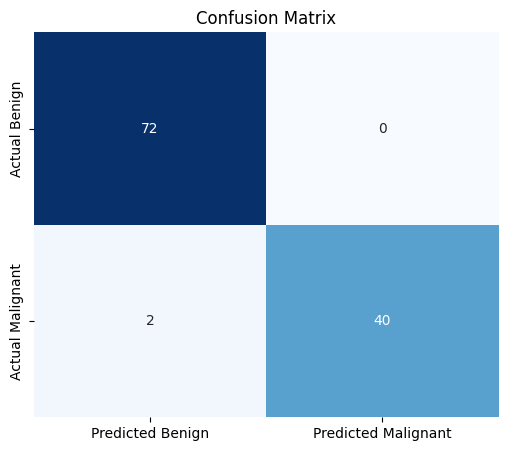

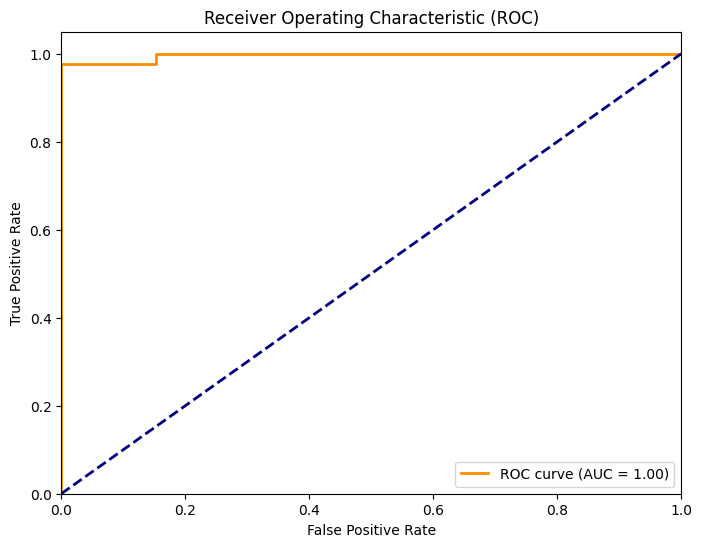

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Get Predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. Classification Report (Precision, Recall, F1)
print("\n--- 📑 Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

# 3. Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Benign', 'Predicted Malignant'],
            yticklabels=['Actual Benign', 'Actual Malignant'])
plt.title('Confusion Matrix')
plt.show()

# 4. ROC Curve (Receiver Operating Characteristic)
# A perfect model hugs the top-left corner
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [6]:
# 1. Save the Model
model.save('cancer_model.keras')
print("✅ Model saved as 'cancer_model.keras'")

# 2. Save the Scaler (CRITICAL!)
# We need this to preprocess new data in the App exactly like we did here
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved as 'scaler.pkl'")

✅ Model saved as 'cancer_model.keras'
✅ Scaler saved as 'scaler.pkl'
